In [1]:
import pandas as pd
import glob
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
# set column width to be able to see full text
pd.set_option('display.max_colwidth', 100)

model_rankings = 'monoT5'

base_path = f'../indexing/results/{model_rankings}/'
# all_model_dirs = glob.glob(f'../indexing/results/{model_rankings}/*')
all_model_csvs = glob.glob(f'{base_path}/*.csv') 
plot_path = f'./plots'
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

In [2]:
number_of_answers = 10

model_dfs = []
for model_csv in all_model_csvs:
    df = pd.read_csv(model_csv)
    model_name = model_csv.split("/")[-1].split(".")[0].replace("_rankings", "")
    df["model"] = model_name
    model_dfs.append(df)

all_model_df = pd.concat(model_dfs, ignore_index=True)
all_model_df['is_natural_question'] = all_model_df['query'].str.endswith('?')
all_model_df


,docno,text,qid,query,score,rank,prompt,answer_number,weighted_position,num_answer_words,num_matching_words,model,is_natural_question
0,gpt2-xl_112,"Asthma is an airway obstruction that causes chronic coughing, wheezing, shortness of breath, dif...",112,symptoms of asthma,-3.157819,58,multimedqa,1,0.276190,385,13,gpt2-xl,False
1,gpt2-xl_109,Ehlers Danlos Syndrome (EDS) is an inherited disorder that causes connective tissue (fatty tissu...,109,ehlers danlos syndrome POTS nausea stomach pain,-4.967661,2,multimedqa,1,0.050000,389,3,gpt2-xl,False
2,gpt2-xl_83,Multiple Sclerosis (MS) is an autoimmune disease that damages the central nervous system causing...,83,Why get episode diagnosed by a doctor as a relapse of multiple sclerosis?,-9.111085,159,multimedqa,1,0.679487,330,19,gpt2-xl,True
3,gpt2-xl_118,What is the difference between Stage 1 and Stage 2 triple negative breast cancer?\nAnswer: The m...,118,stage 4 triple negative breast cancer treatment,-1.564688,50,multimedqa,1,0.224215,340,24,gpt2-xl,False
4,gpt2-xl_81,"Yes, but you must be able to work at least 20 hours per week for your employer or school while s...",81,Can I work and study full-time with multiple sclerosis?,-10.230123,125,multimedqa,1,0.570776,191,11,gpt2-xl,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,gpt2-medium_53,It is the study of mental health issues. \n,53,what is psychotherapy?,-9.155401,34,question,10,0.188889,9,1,gpt2-medium,True
15996,gpt2-medium_108,obesity apathy n=3DQS8HVZ;R9M7JETW4A1X2IHFF6KCPN0G5UYNP\nHere's the video of me doing my 5k run....,108,chronic diarrhea short-term memory sweating inability to regulate body temperature heart palpita...,-10.442990,51,question,10,0.864407,44,0,gpt2-medium,False
15997,gpt2-medium_45,"Yes. With proper use of diet, this disease can be effectively controlled with lifestyle modifica...",45,Can diabetes be cured?,-0.112764,17,question,10,0.134921,212,3,gpt2-medium,True
15998,gpt2-medium_119,"I have a lot of muscle tension issues, so i try and sit on my bed all the time with legs crossed...",119,best pillow neck pain,-11.635513,130,question,10,0.769231,109,0,gpt2-medium,False


In [3]:
# replace na answers with empty string
all_model_df['text'] = all_model_df['text'].fillna('')

In [4]:

# list natural question and non-natural question queries
natural_question_queries = all_model_df[all_model_df['is_natural_question']]['query'].unique()
non_natural_question_queries = all_model_df[~all_model_df['is_natural_question']]['query'].unique()

natural_question_queries, non_natural_question_queries

(array(['Why get episode diagnosed by a doctor as a relapse of multiple sclerosis?',
        'Can I work and study full-time with multiple sclerosis?',
        'How do menopause symptoms relate to multiple sclerosis symptoms?',
        'What are the most common chronic diseases? What effects do chronic diseases have for the society and the individual?',
        'disclosing multiple sclerosis at work, how will colleagues react?',
        'Is a ketogenic / keto diet suitable for people with diabetes?',
        'When will I start to feel better with multiple sclerosis?',
        'Will multiple sclerosis affect my career?',
        'What does multiple sclerosis diagnosis include? What does it change?',
        'What are the most common mental health problems? How can I prevent or manage the most common mental health problems?',
        'What is holistic medicine and what does it include?',
        'How to manage multiple sclerosis?',
        'Does multiple sclerosis relate to sleeping prob

In [5]:
all_model_df['model'].unique()

array(['gpt2-xl', 'chatgpt', 'meta-llama_Llama-2-7b-chat-hf',
       'meta-llama_Llama-2-13b-chat-hf', 'gpt2', 'gpt2-large',
       'tiiuae_falcon-7b-instruct', 'gpt2-medium'], dtype=object)

In [6]:
# rename models to more readable names
names_dict = {
    "gpt2": "GPT-2",
    "gpt2-medium": "GPT-2 Medium",
    "gpt2-large": "GPT-2 Large",
    "gpt2-xl": "GPT-2 XL",
    "tiiuae_falcon-7b-instruct": "Falcon 7B",#
    "meta-llama_Llama-2-7b-chat-hf": "Llama-2 7B",
    "meta-llama_Llama-2-13b-chat-hf": "Llama-2 13B",
    "chatgpt": "ChatGPT"
}
# define colors for models, different shades of same color for different sizes
# gpt2 blue, falcon orange, llama green, chatgpt red
# large models are darker
color_dict = {
    "GPT-2": sns.color_palette("Blues")[0],
    "GPT-2 Medium": sns.color_palette("Blues")[1],
    "GPT-2 Large": sns.color_palette("Blues")[2],
    "GPT-2 XL": sns.color_palette("Blues")[3],
    "Falcon 7B": sns.color_palette("Oranges")[4],
    "Llama-2 7B": sns.color_palette("Greens")[1],
    "Llama-2 13B": sns.color_palette("Greens")[4],
    "ChatGPT": sns.color_palette("Reds")[4]
}

all_model_df['model'] = all_model_df['model'].replace(names_dict)
# order models
order = [
    "GPT-2",
    "GPT-2 Medium",
    "GPT-2 Large",
    "GPT-2 XL",
    "Falcon 7B",
    "Llama-2 7B",
    "Llama-2 13B",
    "ChatGPT",
]
all_model_df['model'] = pd.Categorical(all_model_df['model'], order)


/home/jonas/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonas/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


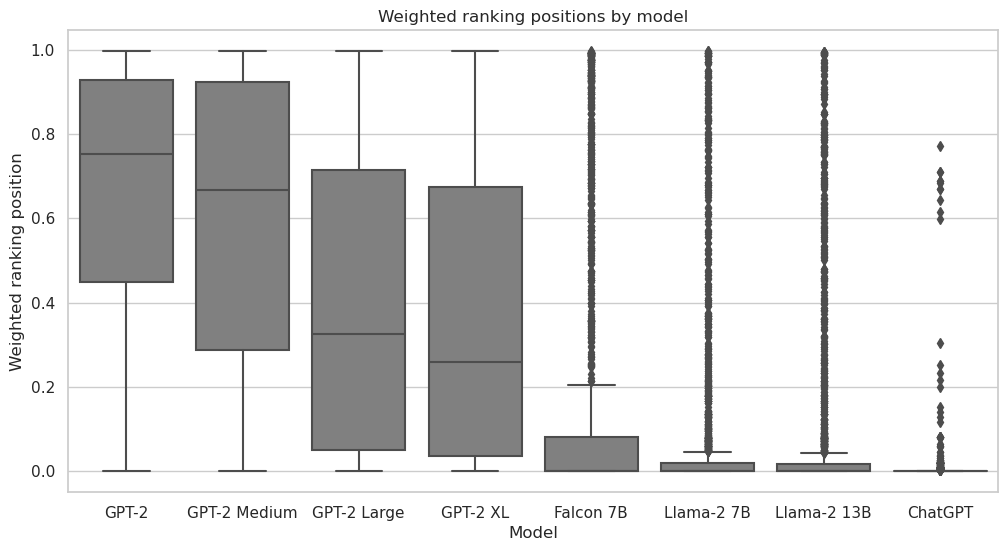

In [46]:
# boxplot of weighted_position
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 6))

# use color_dict to color models
ax = sns.boxplot(x="model", y="weighted_position", data=all_model_df, color="gray")
ax.set_title(f'Weighted ranking positions by model')
ax.set_xlabel('Model')
ax.set_ylabel('Weighted ranking position')
plt.savefig(f'{plot_path}/weighted_position_boxplot.pdf', bbox_inches='tight')
plt.show()

In [8]:
# table with the statistics from the previous boxplot
all_model_df.groupby('model')['weighted_position'].describe()

/tmp/ipykernel_19066/2536731562.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_model_df.groupby('model')['weighted_position'].describe()


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
GPT-2,2000.0,0.660848,0.305756,0.0,0.449256,0.753282,0.927536,0.996000
GPT-2 Medium,2000.0,0.590230,0.342645,0.0,0.287091,0.668142,0.924051,0.996000
GPT-2 Large,2000.0,0.399873,0.345718,0.0,0.050475,0.326028,0.714286,0.995434
GPT-2 XL,2000.0,0.366163,0.342939,0.0,0.035466,0.258286,0.674944,0.995536
Falcon 7B,2000.0,0.146815,0.291233,0.0,0.000000,0.000000,0.082353,0.995968
Llama-2 7B,2000.0,0.079182,0.206323,0.0,0.000000,0.000000,0.018606,0.995968
Llama-2 13B,2000.0,0.081779,0.210085,0.0,0.000000,0.000000,0.017425,0.994924
ChatGPT,2000.0,0.006078,0.052225,0.0,0.000000,0.000000,0.000000,0.771605


/home/jonas/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonas/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


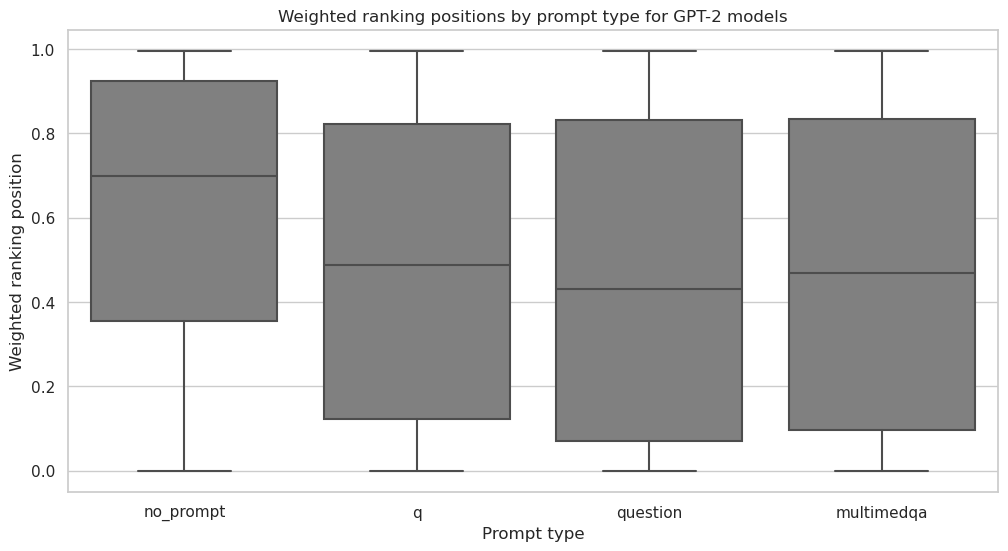

In [47]:
# boxplot of weighted position by prompt type

fig, ax = plt.subplots(figsize=(12, 6))
order = [
    "no_prompt",
    "q",
    "question",
    "multimedqa"
]


# only include models with GPT-2 in name
ax = sns.boxplot(x="prompt", y="weighted_position", data=all_model_df[all_model_df['model'].str.contains("GPT-2")], order=order, color="gray")
ax.set_title(f'Weighted ranking positions by prompt type for GPT-2 models')

ax.set_xlabel('Prompt type')
ax.set_ylabel('Weighted ranking position')
plt.savefig(f'{plot_path}/weighted_position_boxplot_by_prompt.pdf', bbox_inches='tight')
plt.show()


/home/jonas/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonas/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


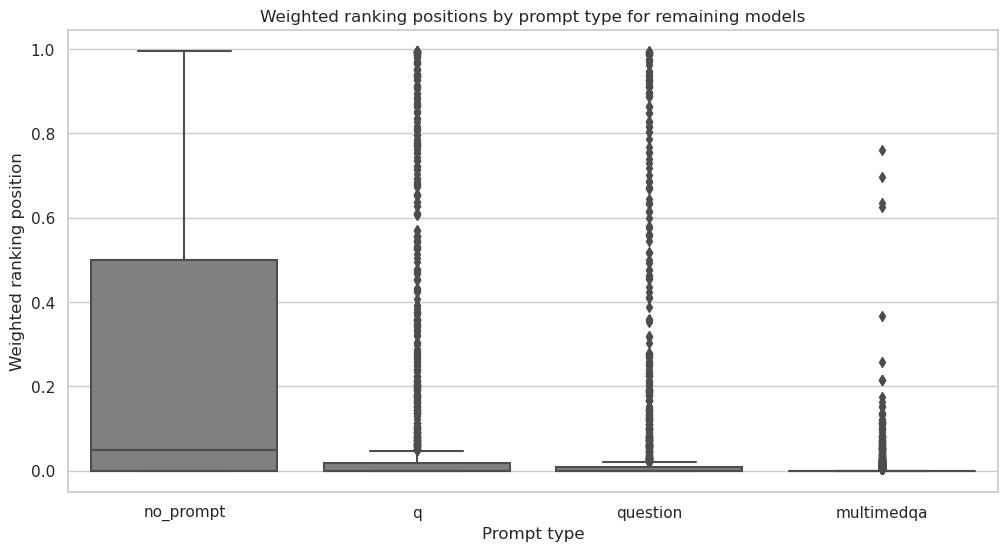

In [48]:
# second plot with remaining models
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.boxplot(x="prompt", y="weighted_position", data=all_model_df[all_model_df['model'].str.contains("Llama") | all_model_df['model'].str.contains("Falcon") ], order=order, color="gray")
ax.set_title(f'Weighted ranking positions by prompt type for remaining models')
ax.set_xlabel('Prompt type')
ax.set_ylabel('Weighted ranking position')
plt.savefig(f'{plot_path}/weighted_position_boxplot_by_prompt_remaining.pdf', bbox_inches='tight')
plt.show()

In [11]:
# table of median rank by model, depending on prompt type
weigthed_position_by_prompt = all_model_df.groupby(['model', 'prompt'])['weighted_position'].mean().unstack()
# order columns
weigthed_position_by_prompt = weigthed_position_by_prompt[order]
# 3 decimals
weigthed_position_by_prompt = weigthed_position_by_prompt.round(3)
weigthed_position_by_prompt.to_csv(f'{plot_path}/weighted_position_by_prompt.csv') 

/tmp/ipykernel_19066/2794833134.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weigthed_position_by_prompt = all_model_df.groupby(['model', 'prompt'])['weighted_position'].mean().unstack()


/home/jonas/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonas/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


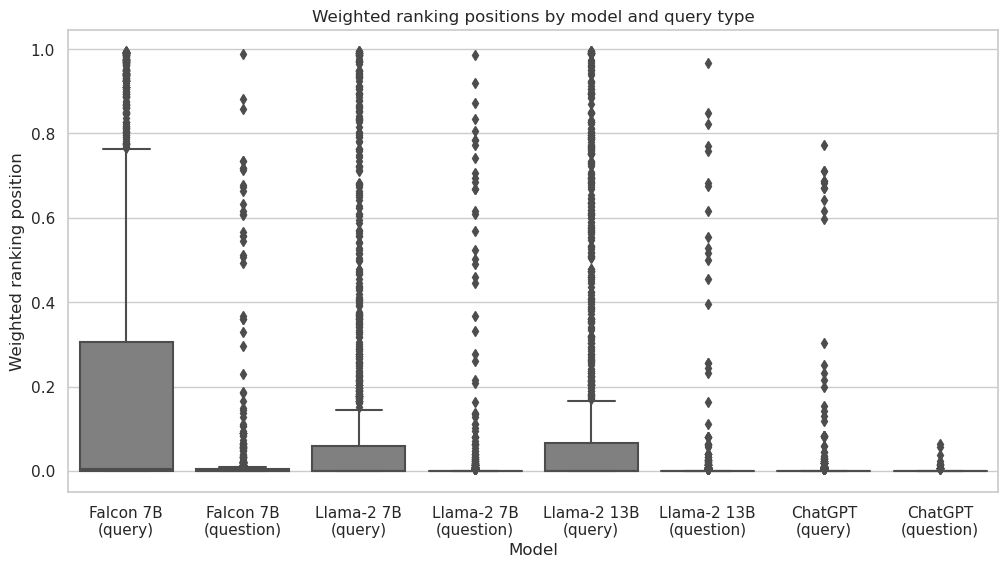

In [45]:
# same boxplot again, but question vs non-question
query_question_df = all_model_df[['docno', 'model', 'weighted_position', 'is_natural_question']]
# drop gpt 2 based model
query_question_df = query_question_df[~query_question_df['model'].str.contains("GPT-2")]

# add query type identifier to model name
# model back to string
query_question_df['model'] = query_question_df['model'].astype(str)
query_question_df['model'] = query_question_df['model'] +  query_question_df['is_natural_question'].map({True: '\n(question)', False: '\n(query)'})
# define same order as before on remaining models
order_with_question = [
    "Falcon 7B\n(query)",
    "Falcon 7B\n(question)",
    "Llama-2 7B\n(query)",
    "Llama-2 7B\n(question)",
    "Llama-2 13B\n(query)",
    "Llama-2 13B\n(question)",
    "ChatGPT\n(query)",
    "ChatGPT\n(question)",
]
query_question_df['model'] = pd.Categorical(query_question_df['model'], order_with_question)
# same color dict as before, adapted to new model names
color_with_question_dict = {
    "Falcon 7B\n(question)": sns.color_palette("Oranges")[1],
    "Falcon 7B\n(query)": sns.color_palette("Oranges")[4],
    "Llama-2 7B\n(question)": sns.color_palette("Greens")[2],
    "Llama-2 7B\n(query)": sns.color_palette("Greens")[1],
    "Llama-2 13B\n(question)": sns.color_palette("Greens")[5],
    "Llama-2 13B\n(query)": sns.color_palette("Greens")[4],
    "ChatGPT\n(question)": sns.color_palette("Reds")[5],
    "ChatGPT\n(query)": sns.color_palette("Reds")[4],
}
# add textures
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.boxplot(x="model", y="weighted_position", data=query_question_df, color="gray")
ax.set_title(f'Weighted ranking positions by model and query type')
ax.set_xlabel('Model')
ax.set_ylabel('Weighted ranking position')

plt.savefig(f'{plot_path}/weighted_position_boxplot_by_model_and_question.pdf', bbox_inches='tight')
plt.show()


In [13]:
# table with the statistics from the previous boxplot, for all models
all_model_df.groupby(['model', 'is_natural_question', 'prompt'])['weighted_position'].describe()

/tmp/ipykernel_19066/4211196041.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_model_df.groupby(['model', 'is_natural_question', 'prompt'])['weighted_position'].describe()


count      mean       std       min  \
model   is_natural_question prompt                                            
GPT-2   False               multimedqa  330.0  0.702771  0.287479  0.000000   
                            no_prompt   330.0  0.825880  0.195803  0.000000   
                            q           330.0  0.741832  0.257434  0.009662   
                            question    330.0  0.706448  0.289884  0.000000   
        True                multimedqa  170.0  0.409872  0.308804  0.000000   
...                                       ...       ...       ...       ...   
ChatGPT False               question    330.0  0.010092  0.069538  0.000000   
        True                multimedqa  170.0  0.000935  0.005363  0.000000   
                            no_prompt   170.0  0.000873  0.003973  0.000000   
                            q           170.0  0.000601  0.004593  0.000000   
                            question    170.0  0.000420  0.001782  0.000000   

                                             25%       50%       75%       max  
model   is_natural_question prompt                                              
GPT-2   False               multimedqa  0.535650  0.794076  0.934366  0.995968  
                            no_prompt   0.759403  0.908000  0.964497  0.996000  
                            q           0.614407  0.838846  0.940328  0.995536  
                            question    0.524501  0.820971  0.943772  0.995516  
        True                multimedqa  0.111718  0.366300  0.697101  0.992000  
...                                          ...       ...       ...       ...  
ChatGPT False               question    0.000000  0.000000  0.000000  0.710407  
        True                multimedqa  0.000000  0.000000  0.000000  0.063492  
                            no_prompt   0.000000  0.000000  0.000000  0.037559  
                            q           0.000000  0.000000  0.000000  0.056338  
                            question    0.000000  0.000000  0.000000  0.007937  

[64 rows x 8 columns]

/home/jonas/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonas/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


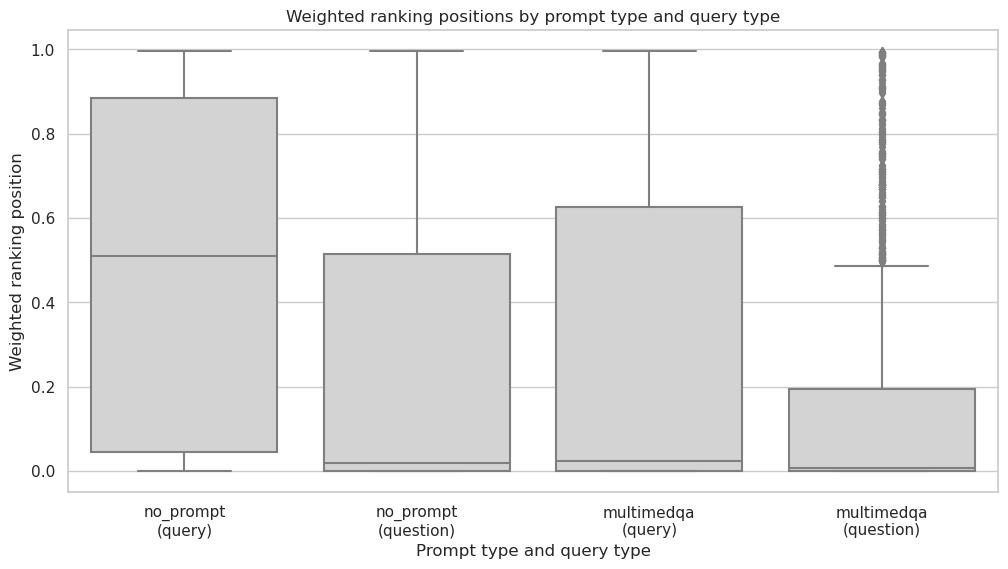

In [49]:
# boxplot of query vs. question type queries for no prompt and multimedqa
query_prompt_df = all_model_df
# merge prompt type and question type columns
query_prompt_df['query_prompt'] = query_prompt_df['prompt'] + query_prompt_df['is_natural_question'].map({True: '\n(question)', False: '\n(query)'})

order = [
    "no_prompt\n(query)",
    "no_prompt\n(question)",
    "multimedqa\n(query)",
    "multimedqa\n(question)",
]

fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.boxplot(x="query_prompt", y="weighted_position", data=query_prompt_df, order=order, color="lightgray")
ax.set_title(f'Weighted ranking positions by prompt type and query type')
ax.set_xlabel('Prompt type and query type')
ax.set_ylabel('Weighted ranking position')
plt.savefig(f'{plot_path}/weighted_position_boxplot_by_prompt_and_question.pdf', bbox_inches='tight')
plt.show()

In [15]:
stats_per_model = all_model_df.groupby(['model']).agg({'weighted_position': ['mean', 'std'], 'num_answer_words': ['mean', 'std'], 'num_matching_words': ['mean', 'std']})
stats_per_model.columns = ['_'.join(col) for col in stats_per_model.columns.values]
stats_per_model = stats_per_model.reset_index()
stats_per_model = stats_per_model.sort_values(by=['weighted_position_mean'])
stats_per_model

/tmp/ipykernel_19066/880070476.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_per_model = all_model_df.groupby(['model']).agg({'weighted_position': ['mean', 'std'], 'num_answer_words': ['mean', 'std'], 'num_matching_words': ['mean', 'std']})


,model,weighted_position_mean,weighted_position_std,num_answer_words_mean,num_answer_words_std,num_matching_words_mean,num_matching_words_std
7,ChatGPT,0.006078,0.052225,220.8390,90.595071,18.6545,15.635868
5,Llama-2 7B,0.079182,0.206323,231.8830,98.199832,13.1375,11.640547
6,Llama-2 13B,0.081779,0.210085,248.2105,97.279869,16.3765,14.799705
4,Falcon 7B,0.146815,0.291233,113.2990,101.749143,13.6155,29.175268
3,GPT-2 XL,0.366163,0.342939,281.0190,130.791008,9.2440,11.622565
2,GPT-2 Large,0.399873,0.345718,288.8100,134.563950,9.2540,12.587641
1,GPT-2 Medium,0.590230,0.342645,212.0685,135.578732,1.4190,2.120303
0,GPT-2,0.660848,0.305756,234.9285,128.802401,1.4330,2.213812


In [16]:
# the 10 worst answers for each model
worst_answers_df = all_model_df.sort_values(by=['weighted_position'], ascending=False).groupby('model').head(number_of_answers)
worst_answers_df.to_csv(f'{plot_path}/worst_answers.csv', index=False)

/tmp/ipykernel_19066/1092020685.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  worst_answers_df = all_model_df.sort_values(by=['weighted_position'], ascending=False).groupby('model').head(number_of_answers)


In [17]:
# the worst ranked answers by chatgpt as csv
chatgpt_df = all_model_df[all_model_df['model'] == 'ChatGPT']
chatgpt_df = chatgpt_df.sort_values(by=['weighted_position'], ascending=False)
# get answers with weighted_position < 0.2
chatgpt_df_worst = chatgpt_df[chatgpt_df['weighted_position'] > 0.1]
chatgpt_df_worst.to_csv(f'{plot_path}/chatgpt_worst_ranked.csv')


In [18]:
# queries represented in the worst answers
chatgpt_df_worst['query'].unique()

array(['hypothyroidism symptoms', 'List of multiple sclerosis symptoms',
       'my risk for developing type 2 diabetes',
       'exercises for better posture'], dtype=object)

In [19]:
# csv with all answers for qid 68 by chatgpt, order by weighted_position
chatgpt_df_qid_68 = chatgpt_df[chatgpt_df['qid'] == 68]
chatgpt_df_qid_68 = chatgpt_df_qid_68.sort_values(by=['weighted_position'], ascending=False)
chatgpt_df_qid_68.to_csv(f'{plot_path}/chatgpt_qid_68.csv', index=False)

In [20]:
# number of answers per model that contain "as an AI language model" in the lowercased text
all_model_df['as_an_ai'] = all_model_df['text'].str.lower().str.contains("as an ai language model")
all_model_df['dont_know'] = all_model_df['text'].str.lower().str.contains("don't know")
all_model_df['sorry'] = all_model_df['text'].str.lower().str.contains("sorry")

all_model_df.groupby('model')[['as_an_ai', 'dont_know', 'sorry']].sum()

/tmp/ipykernel_19066/1237975087.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_model_df.groupby('model')[['as_an_ai', 'dont_know', 'sorry']].sum()


,as_an_ai,dont_know,sorry
model,,,
GPT-2,0,78,28
GPT-2 Medium,0,76,28
GPT-2 Large,0,79,13
GPT-2 XL,0,64,9
Falcon 7B,30,3,46
Llama-2 7B,1,9,6
Llama-2 13B,0,3,14
ChatGPT,20,0,13


In [21]:
# average rank of flacon answers that contain the phrase "as an AI language model" vs those that don't
falcon_df = all_model_df[all_model_df['model'] == 'Falcon 7B']
falcon_df.groupby('as_an_ai')['weighted_position'].mean()

as_an_ai
False    0.146142
True     0.190963
Name: weighted_position, dtype: float64

In [22]:
# correlation between number of matching words and weighted position, by model
all_model_df.groupby('model')[['num_matching_words', 'weighted_position']].corr()

/tmp/ipykernel_19066/2701435817.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_model_df.groupby('model')[['num_matching_words', 'weighted_position']].corr()


num_matching_words  weighted_position
model                                                                 
GPT-2        num_matching_words            1.000000          -0.366283
             weighted_position            -0.366283           1.000000
GPT-2 Medium num_matching_words            1.000000          -0.388167
             weighted_position            -0.388167           1.000000
GPT-2 Large  num_matching_words            1.000000          -0.394804
             weighted_position            -0.394804           1.000000
GPT-2 XL     num_matching_words            1.000000          -0.384130
             weighted_position            -0.384130           1.000000
Falcon 7B    num_matching_words            1.000000          -0.158740
             weighted_position            -0.158740           1.000000
Llama-2 7B   num_matching_words            1.000000          -0.322673
             weighted_position            -0.322673           1.000000
Llama-2 13B  num_matching_words            1.000000          -0.321954
             weighted_position            -0.321954           1.000000
ChatGPT      num_matching_words            1.000000          -0.100038
             weighted_position            -0.100038           1.000000

In [23]:
# queries on which chatgpt performs worst on average
chatgpt_df = all_model_df[all_model_df['model'] == 'ChatGPT']
chatgpt_df.groupby('query')['weighted_position'].mean().sort_values(ascending=False).head(10)

query
List of multiple sclerosis symptoms         0.166855
exercises for better posture                0.031471
my risk for developing type 2 diabetes      0.028800
hypothyroidism symptoms                     0.019290
borderline personality disorder symptoms    0.017130
asthma and covid                            0.013356
Can diabetes be cured?                      0.007738
outcome prostate cancer                     0.006048
Relapsing remitting multiple sclerosis      0.003807
benefits of physical activity               0.002915
Name: weighted_position, dtype: float64

In [24]:
chatgpt_df

,docno,text,qid,query,score,rank,prompt,answer_number,weighted_position,num_answer_words,num_matching_words,model,is_natural_question,query_prompt,as_an_ai,dont_know,sorry
2000,chatgpt_114,Borderline personality disorder (BPD) is a mental health condition characterized by a pervasive ...,114,borderline personality disorder symptoms,-0.021312,2,multimedqa,1,0.018519,313,5,ChatGPT,False,multimedqa\n(query),False,False,False
2001,chatgpt_95,"Multiple sclerosis (MS) can cause various visual symptoms, including reading problems. This is o...",95,Reading problems in MS,-0.005046,0,multimedqa,1,0.000000,277,23,ChatGPT,False,multimedqa\n(query),False,False,False
2002,chatgpt_123,Hypothyroidism is a condition that occurs when the thyroid gland in the neck does not produce en...,123,hypothyroidism symptoms,-0.039711,0,multimedqa,1,0.000000,156,6,ChatGPT,False,multimedqa\n(query),False,False,False
2003,chatgpt_72,"Yes, the Covid-19 vaccine is generally considered safe for people taking multiple sclerosis (MS)...",72,Is the Covid-19 vaccine safe for people taking multiple sclerosis drugs?,-0.001719,0,multimedqa,1,0.000000,254,47,ChatGPT,True,multimedqa\n(question),False,False,False
2004,chatgpt_53,"Psychotherapy, also known as talk therapy or psychological therapy, is a form of treatment that ...",53,what is psychotherapy?,-0.027289,0,multimedqa,1,0.000000,279,4,ChatGPT,True,multimedqa\n(question),False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,chatgpt_55,"Managing multiple sclerosis (MS) involves a combination of medical treatments, lifestyle modific...",55,How to manage multiple sclerosis?,-0.002645,0,no_prompt,10,0.000000,363,14,ChatGPT,True,no_prompt\n(question),False,False,False
3996,chatgpt_94,"I'm not a doctor, but I can provide some general information. The course and progression of mult...",94,When will I start to feel better with multiple sclerosis?,-0.026092,0,no_prompt,10,0.000000,189,21,ChatGPT,True,no_prompt\n(question),False,False,False
3997,chatgpt_58,"The exact cause of multiple sclerosis (MS) is still unknown, but there are several risk factors ...",58,Risk to develop multiple sclerosis,-0.031655,0,no_prompt,10,0.000000,243,19,ChatGPT,False,no_prompt\n(query),False,False,False
3998,chatgpt_118,The treatment for stage 4 triple negative breast cancer typically involves a combination of ther...,118,stage 4 triple negative breast cancer treatment,-0.002084,0,no_prompt,10,0.000000,263,34,ChatGPT,False,no_prompt\n(query),False,False,False


In [25]:
# annotated answers with 'list_style' column, if at most one line does not start with a number or a dash

def is_list_style(text):
    if type(text) != str:
        return False
    lines = text.split("\n")
    # remove empty lines
    lines = [line for line in lines if line.strip() != ""]
    # remove texts with less than 5 lines
    if len(lines) < 5:
        return False
    # remove lines that start with a number or a dash
    lines = [line for line in lines if not line.strip()[0].isdigit() and not line.strip()[0] == "-"]
    # if at most one line remains, it is list style
    return len(lines) <= 2

all_model_df['list_style'] = all_model_df['text'].apply(is_list_style)
# list style answers by model
all_model_df.groupby('model')['list_style'].sum()

/tmp/ipykernel_19066/3459540348.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_model_df.groupby('model')['list_style'].sum()


model
GPT-2             0
GPT-2 Medium      0
GPT-2 Large      36
GPT-2 XL         22
Falcon 7B        38
Llama-2 7B      266
Llama-2 13B     427
ChatGPT         748
Name: list_style, dtype: int64

In [26]:
# get all count of all answers that are list style for each model and qid and not list style
answer_count_df = all_model_df.groupby(['model', 'qid', 'list_style'])['docno'].count().unstack()
answer_count_df

/tmp/ipykernel_19066/1718833315.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  answer_count_df = all_model_df.groupby(['model', 'qid', 'list_style'])['docno'].count().unstack()


list_style   False  True 
model   qid              
GPT-2   1       40      0
        8       40      0
        22      40      0
        35      40      0
        45      40      0
...            ...    ...
ChatGPT 126     40      0
        127     29     11
        130      0     40
        131      0     40
        132     38      2

[400 rows x 2 columns]

In [27]:
# average weighted position of list style vs non-list style answers by model. add an extra column to the dataframe containing the total number of answers for that category

qid_list_style_df = all_model_df.groupby(['model', 'qid', 'list_style']).agg({'weighted_position': ['mean'], 'docno': ['count']})
# only chatgpt results
qid_list_style_df = qid_list_style_df[qid_list_style_df.index.get_level_values('model') == 'ChatGPT']
# from the all_model_df, get unique qids where chatgpt has at least one list style answer
qids_with_list_answers = all_model_df[all_model_df['model'] == 'ChatGPT'][all_model_df['list_style'] == True]['qid'].unique()
# from whose qids, remove those where chatgpt has no non-list style answers
qids_with_list_answers = [qid for qid in qids_with_list_answers if qid in all_model_df[all_model_df['model'] == 'ChatGPT'][all_model_df['list_style'] == False]['qid'].unique()]

# filter qid_list_style_df to only contain these qids
qid_list_style_df = qid_list_style_df[qid_list_style_df.index.get_level_values('qid').isin(qids_with_list_answers)]


qid_list_style_df

/tmp/ipykernel_19066/1172701303.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  qid_list_style_df = all_model_df.groupby(['model', 'qid', 'list_style']).agg({'weighted_position': ['mean'], 'docno': ['count']})
/tmp/ipykernel_19066/1172701303.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  qids_with_list_answers = all_model_df[all_model_df['model'] == 'ChatGPT'][all_model_df['list_style'] == True]['qid'].unique()
/tmp/ipykernel_19066/1172701303.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  qids_with_list_answers = [qid for qid in qids_with_list_answers if qid in all_model_df[all_model_df['model'] == 'ChatGPT'][all_model_df['list_style'] == False]['qid'].unique()]
/tmp/ipykernel_19066/1172701303.py:9: UserWarning: Boolean 

weighted_position docno
                                    mean count
model   qid list_style                        
ChatGPT 22  False               0.104364    11
            True                0.000138    29
        35  False               0.000349    37
            True                0.000000     3
        51  False               0.000000    38
            True                0.000000     2
        52  False               0.000000    19
            True                0.000000    21
        54  False               0.000232    35
            True                0.000000     5
        57  False               0.000000    11
            True                0.000000    29
        58  False               0.000000    10
            True                0.000000    30
        59  False               0.000000    26
            True                0.000000    14
        62  False               0.000000    25
            True                0.000000    15
        63  False               0.000000    39
            True                0.000000     1
        77  False               0.000000    37
            True                0.000000     3
        81  False               0.000000    37
            True                0.000000     3
        83  False               0.000000    14
            True                0.000000    26
        92  False               0.000000     3
            True                0.000000    37
        95  False               0.000000    23
            True                0.000000    17
        96  False               0.000000     4
            True                0.000000    36
        97  False               0.000000     7
            True                0.003533    33
        101 False               0.000000    31
            True                0.000000     9
        102 False               0.000583    35
            True                0.000000     5
        105 False               0.000000    31
            True                0.000000     9
        107 False               0.000000    35
            True                0.000000     5
        108 False               0.000000    39
            True                0.000000     1
        112 False               0.000000     6
            True                0.000000    34
        118 False               0.000000    23
            True                0.000000    17
        119 False               0.000000     3
            True                0.000000    37
        123 False               0.000000     6
            True                0.022694    34
        127 False               0.000000    29
            True                0.000000    11
        132 False               0.000000    38
            True                0.000000     2

In [28]:
# calculate if the difference in weighted position is significant
import scipy.stats as stats
# get list style answers
list_style_answers = qid_list_style_df[qid_list_style_df.index.get_level_values('list_style') == True]['weighted_position']
# get non-list style answers
non_list_style_answers = qid_list_style_df[qid_list_style_df.index.get_level_values('list_style') == False]['weighted_position']
# calculate t-test
stats.ttest_ind(list_style_answers, non_list_style_answers)

TtestResult(statistic=array([-0.74127563]), pvalue=array([0.46173797]), df=array([54.]))

In [29]:
list_style_answers

mean
model   qid list_style          
ChatGPT 22  True        0.000138
        35  True        0.000000
        51  True        0.000000
        52  True        0.000000
        54  True        0.000000
        57  True        0.000000
        58  True        0.000000
        59  True        0.000000
        62  True        0.000000
        63  True        0.000000
        77  True        0.000000
        81  True        0.000000
        83  True        0.000000
        92  True        0.000000
        95  True        0.000000
        96  True        0.000000
        97  True        0.003533
        101 True        0.000000
        102 True        0.000000
        105 True        0.000000
        107 True        0.000000
        108 True        0.000000
        112 True        0.000000
        118 True        0.000000
        119 True        0.000000
        123 True        0.022694
        127 True        0.000000
        132 True        0.000000

In [30]:
all_model_df.head()

,docno,text,qid,query,score,rank,prompt,answer_number,weighted_position,num_answer_words,num_matching_words,model,is_natural_question,query_prompt,as_an_ai,dont_know,sorry,list_style
0,gpt2-xl_112,"Asthma is an airway obstruction that causes chronic coughing, wheezing, shortness of breath, dif...",112,symptoms of asthma,-3.157819,58,multimedqa,1,0.276190,385,13,GPT-2 XL,False,multimedqa\n(query),False,False,False,False
1,gpt2-xl_109,Ehlers Danlos Syndrome (EDS) is an inherited disorder that causes connective tissue (fatty tissu...,109,ehlers danlos syndrome POTS nausea stomach pain,-4.967661,2,multimedqa,1,0.050000,389,3,GPT-2 XL,False,multimedqa\n(query),False,False,False,False
2,gpt2-xl_83,Multiple Sclerosis (MS) is an autoimmune disease that damages the central nervous system causing...,83,Why get episode diagnosed by a doctor as a relapse of multiple sclerosis?,-9.111085,159,multimedqa,1,0.679487,330,19,GPT-2 XL,True,multimedqa\n(question),False,False,False,False
3,gpt2-xl_118,What is the difference between Stage 1 and Stage 2 triple negative breast cancer?\nAnswer: The m...,118,stage 4 triple negative breast cancer treatment,-1.564688,50,multimedqa,1,0.224215,340,24,GPT-2 XL,False,multimedqa\n(query),False,False,False,False
4,gpt2-xl_81,"Yes, but you must be able to work at least 20 hours per week for your employer or school while s...",81,Can I work and study full-time with multiple sclerosis?,-10.230123,125,multimedqa,1,0.570776,191,11,GPT-2 XL,True,multimedqa\n(question),False,False,False,False


In [31]:
all_model_df[all_model_df['sorry'] == True]

,docno,text,qid,query,score,rank,prompt,answer_number,weighted_position,num_answer_words,num_matching_words,model,is_natural_question,query_prompt,as_an_ai,dont_know,sorry,list_style
15,gpt2-xl_102,Your skin has been exposed to a lot of stressors in the last few days (stress is caused by an en...,102,randomly gotten eczema,-7.910106,45,multimedqa,1,0.459184,413,0,GPT-2 XL,False,multimedqa\n(query),False,False,True,False
492,gpt2-xl_117,\1/ You have had stage IV lung cancer (CML) treated with chemotherapy and radiation therapy. \2/...,117,stage 4 metastatic lung cancer outcome,-8.130675,50,multimedqa,10,0.201613,135,6,GPT-2 XL,False,multimedqa\n(query),False,False,True,False
551,gpt2-xl_109,I can't imagine what it would be like for someone to have a kidney removed. I'm not sure how man...,109,ehlers danlos syndrome POTS nausea stomach pain,-9.677335,25,q,2,0.625000,406,4,GPT-2 XL,False,q\n(query),False,False,True,False
558,gpt2-xl_62,I'm working in a department that is very liberal and open. My supervisor knows about my MS diagn...,62,"disclosing multiple sclerosis at work, how will colleagues react?",-0.063663,11,q,2,0.050000,429,2,GPT-2 XL,True,q\n(question),False,False,True,False
626,gpt2-xl_107,"Yes, I do. A: Do you feel like it's your fault? B: No. What are you talking about? A: You're tak...",107,medication adhd anxiety,-10.622978,75,q,3,0.581395,252,3,GPT-2 XL,False,q\n(query),False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15784,gpt2-medium_86,Yes. Multiple Sclerosis is a disease caused by the immune system attacking your body's tissues (...,86,Secondary progressive multiple sclerosis,-11.167350,119,question,6,0.894737,315,2,GPT-2 Medium,False,question\n(query),False,False,True,False
15853,gpt2-medium_118,I have done a lot of research and learned that there are treatments for this disease. Unfortunat...,118,stage 4 triple negative breast cancer treatment,-13.332398,208,question,8,0.932735,190,1,GPT-2 Medium,False,question\n(query),False,False,True,False
15862,gpt2-medium_121,I've had this for about 6 years now and it has become worse every year. It's so bad that my doct...,121,numb fingers arthritis,-13.765941,174,question,8,0.977528,320,0,GPT-2 Medium,False,question\n(query),False,False,True,False
15910,gpt2-medium_97,"the main benefit is reduced risk for coronary heart disease, and weight loss\nThe National Heart...",97,benefits of physical activity,-3.863832,86,question,9,0.385650,407,3,GPT-2 Medium,False,question\n(query),False,False,True,False


In [32]:
# all answers for 

In [33]:
# For ChatGPT, compare the mean weighted position of answers that contain the phrase "as an AI language model" vs those that don't, separated by qid
chatgpt_df = all_model_df[all_model_df['model'] == 'ChatGPT']
chatgpt_df = chatgpt_df.groupby(['list_style', 'qid'])['weighted_position'].mean().unstack()
# drop columns with NaN values
chatgpt_df = chatgpt_df.dropna(axis=1)
chatgpt_df

qid,22,35,51,52,54,57,58,59,62,63,...,102,105,107,108,112,118,119,123,127,132
list_style,,,,,,,,,,,,,,,,,,,,,
False,0.104364,0.000349,0.0,0.0,0.000232,0.0,0.0,0.0,0.0,0.0,...,0.000583,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
True,0.000138,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.022694,0.0,0.0


In [34]:
# generate df that has one row per Model, and one column for sorry, not sorry, don't know, not don't know, contains ai, not contains ai and list style, not list style
# each cell contains the average weighted position of those answers

# sorry, not sorry, don't know, not don't know, contains ai, not contains ai and list style, not list style
# sorry
models_list = all_model_df['model'].unique()
df_collection = []
count_collection = []
for column in ['sorry', 'dont_know', 'as_an_ai', 'list_style']:
    df = all_model_df[all_model_df[column] == True]
    df = df.groupby('model')['weighted_position'].mean()
    df.columns = [column]
    df_collection.append(df)

    count_df = all_model_df[all_model_df[column] == True]
    count_df = count_df.groupby('model').size()
    count_df.columns = [f'{column}_count']
    count_collection.append(count_df)

    negative_df = all_model_df[all_model_df[column] == False]
    negative_df = negative_df.groupby('model')['weighted_position'].mean()
    negative_df.columns = [f'not_{column}']
    df_collection.append(negative_df)

    negative_count_df = all_model_df[all_model_df[column] == False]
    negative_count_df = negative_count_df.groupby('model').size()
    negative_count_df.columns = [f'not_{column}_count']
    count_collection.append(negative_count_df)

# concat all dfs
df_collection = pd.concat(df_collection, axis=1)
count_collection = pd.concat(count_collection, axis=1)

df_collection = df_collection.reset_index()
count_collection = count_collection.reset_index()

# rename columns
df_collection.columns = ['model', 'sorry', 'not_sorry', 'dont_know', 'not_dont_know', 'as_an_ai', 'not_as_an_ai', 'list_style', 'not_list_style']
count_collection.columns = ['model', 'sorry_count', 'not_sorry_count', 'dont_know_count', 'not_dont_know_count', 'as_an_ai_count', 'not_as_an_ai_count', 'list_style_count', 'not_list_style_count']

# round 
df_collection = df_collection.round(4)

# merge the dataframes
df_collection = pd.merge(df_collection, count_collection, on='model')
# only keep as_an_ai and not_as_an_ai and list_style and not_list_style
df_collection = df_collection[['model', 'as_an_ai', 'not_as_an_ai', 'list_style', 'not_list_style', 'as_an_ai_count', 'not_as_an_ai_count', 'list_style_count', 'not_list_style_count']]
df_collection.to_csv(f'{plot_path}/weighted_position_by_answer_attributes.csv', index=False)

/tmp/ipykernel_19066/2121561977.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby('model')['weighted_position'].mean()
/tmp/ipykernel_19066/2121561977.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = count_df.groupby('model').size()
/tmp/ipykernel_19066/2121561977.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  negative_df = negative_df.groupby('model')['weighted_position'].mean()
/

In [35]:
# avaerage weighted position of list style answers vs non-list style answers by model. Add number of list style answers and non-list style answers to df
is_list_style_query_performance = all_model_df[all_model_df['model'] == "ChatGPT"].groupby(['model', 'qid'])[['list_style', 'weighted_position']].corr()
is_list_style_query_performance = is_list_style_query_performance.reset_index()
is_list_style_query_performance = is_list_style_query_performance[is_list_style_query_performance['level_2'] == 'list_style']
is_list_style_query_performance = is_list_style_query_performance[['model', 'qid', 'weighted_position']]
is_list_style_query_performance.columns = ['model', 'qid', 'corr']
# add columns with number of list style answers and non-list style answers for qid
is_list_style_query_performance['num_list_style'] = is_list_style_query_performance['qid'].apply(lambda x: all_model_df[(all_model_df['model'] == "ChatGPT") & (all_model_df['qid'] == x)]['list_style'].sum())
is_list_style_query_performance['num_non_list_style'] = is_list_style_query_performance['qid'].apply(lambda x: all_model_df[(all_model_df['model'] == "ChatGPT") & (all_model_df['qid'] == x)]['list_style'].count() - all_model_df[(all_model_df['model'] == "ChatGPT") & (all_model_df['qid'] == x)]['list_style'].sum())
# drop rows with NaN in corr
is_list_style_query_performance = is_list_style_query_performance.dropna()


/tmp/ipykernel_19066/4219727226.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  is_list_style_query_performance = all_model_df[all_model_df['model'] == "ChatGPT"].groupby(['model', 'qid'])[['list_style', 'weighted_position']].corr()


In [36]:
is_list_style_query_performance

,model,qid,corr,num_list_style,num_non_list_style
4,ChatGPT,22,-0.609432,29,11
6,ChatGPT,35,-0.045596,3,37
16,ChatGPT,54,-0.086711,5,35
56,ChatGPT,97,0.166637,33,7
62,ChatGPT,102,-0.086711,5,35
88,ChatGPT,123,0.067267,34,6


In [ ]:
hf_llm_leaderboard = pd.read_csv('huggingface_llm_leaderboards.csv')

hf_llm_leaderboard['model'] = hf_llm_leaderboard['model'].replace(names_dict)

In [ ]:
joined_df = pd.merge(hf_llm_leaderboard, stats_per_model, on='model', how='left')
# only keep cols model, ARC, HellaSwag, MMLU, weighted_position_mean in joined_df
joined_df = joined_df[['model', 'ARC', 'HellaSwag', 'MMLU', 'weighted_position_mean']]
joined_df = joined_df.rename(columns={'weighted_position_mean': 'weighted_position'})
# move weighted_position to the beginning of the df
joined_df = joined_df[['model', 'weighted_position', 'ARC', 'HellaSwag', 'MMLU']]
# reanme models
# order by weighted_position
joined_df = joined_df.sort_values(by=['weighted_position'], ascending=False)
# round weighted_position to 3 decimals
joined_df['weighted_position'] = joined_df['weighted_position'].round(3)

joined_df.to_csv('llm_positions.csv', index=False)

/home/jonas/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonas/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonas/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


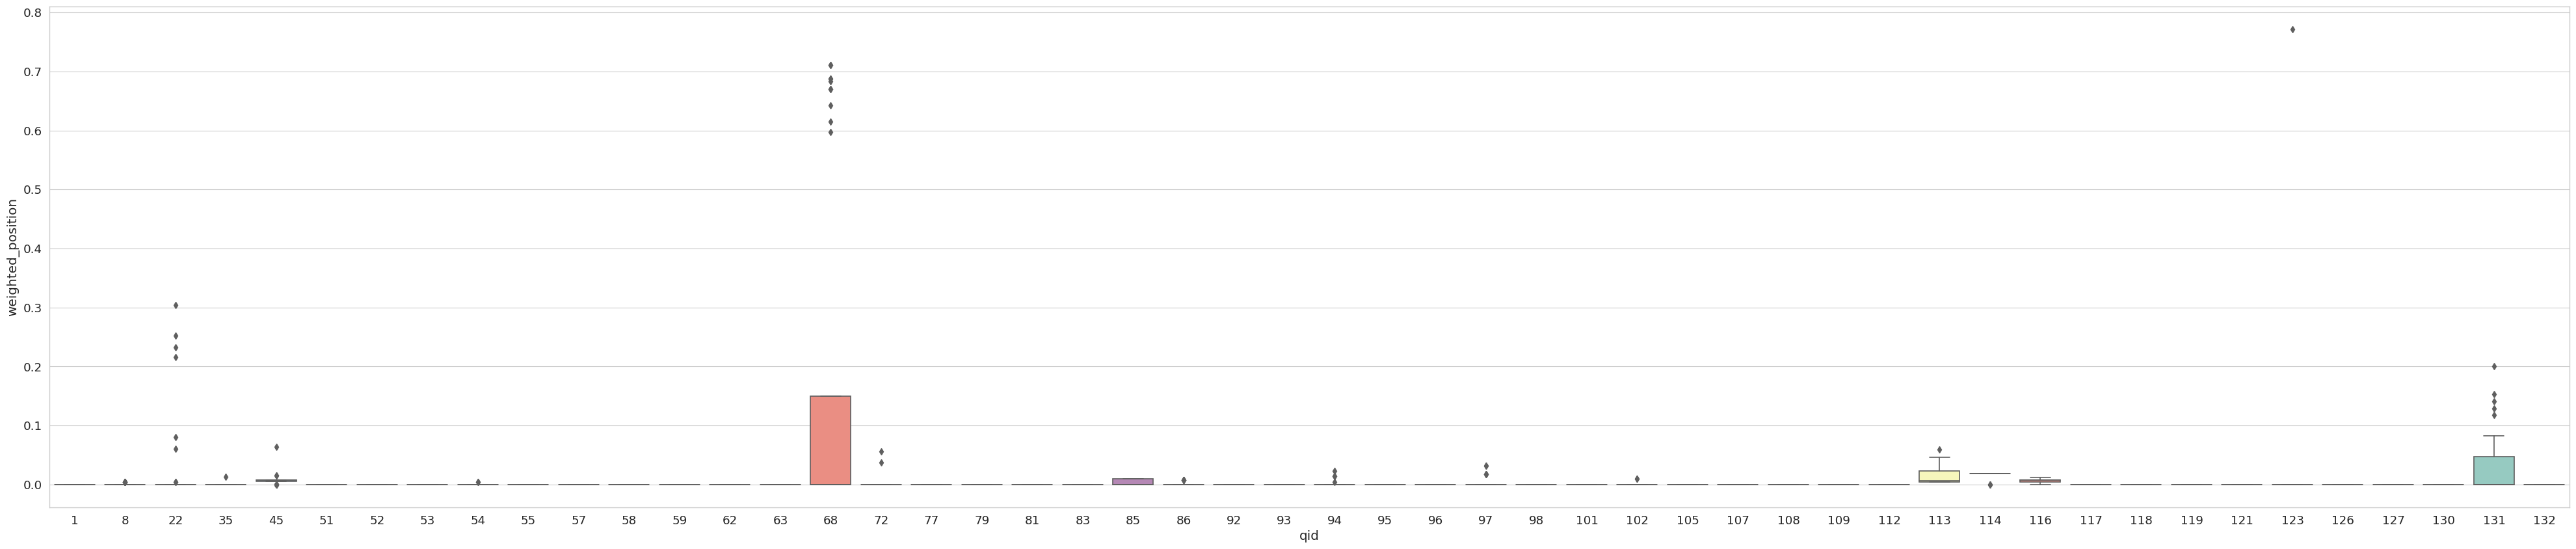

In [ ]:
# make this into a nice boxplot
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
# increase plot size
plt.rcParams["figure.figsize"] = (50, 10)
model_order = ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl', 'tiiuae_falcon-7b-instruct', 'meta-llama_Llama-2-7b-chat-hf', 'meta-llama_Llama-2-13b-chat-hf', 'chatgpt']

plt = sns.boxplot(x="qid", y="weighted_position", data=all_model_df[all_model_df['model'] == 'chatgpt'], palette="Set3")

In [ ]:
stats_per_prompt = all_model_df.groupby(['prompt']).agg({'weighted_position': ['mean', 'std'], 'num_answer_words': ['mean', 'std'], 'num_matching_words': ['mean', 'std']})
stats_per_prompt.columns = ['_'.join(col) for col in stats_per_prompt.columns.values]
stats_per_prompt = stats_per_prompt.reset_index()
stats_per_prompt = stats_per_prompt.sort_values(by=['weighted_position_mean'])
stats_per_prompt

,prompt,weighted_position_mean,weighted_position_std,num_answer_words_mean,num_answer_words_std,num_matching_words_mean,num_matching_words_std
0,multimedqa,0.239411,0.344033,258.74975,114.394550,11.75425,13.526921
3,question,0.250514,0.348299,222.28875,124.296926,10.65900,17.799099
2,q,0.275188,0.353243,224.05275,127.659056,10.07525,16.956576
1,no_prompt,0.400371,0.383879,210.43750,134.167669,9.07850,15.100442


In [ ]:
stats_per_query = all_model_df.groupby(['qid', 'query']).agg({'weighted_position': ['mean', 'std'], 'num_answer_words': ['mean', 'std'], 'num_matching_words': ['mean', 'std']})
stats_per_query.columns = ['_'.join(col) for col in stats_per_query.columns.values]
stats_per_query = stats_per_query.reset_index()
stats_per_query = stats_per_query.sort_values(by=['weighted_position_mean'])
stats_per_query = stats_per_query.reset_index(drop=True)
stats_per_query

,qid,query,weighted_position_mean,weighted_position_std,num_answer_words_mean,num_answer_words_std,num_matching_words_mean,num_matching_words_std
0,93,Does multiple sclerosis relate to sleeping problems and forgetfulness in older people?,0.069792,0.187819,250.721875,125.346520,19.540625,12.857243
1,1,What are the most common chronic diseases? What effects do chronic diseases have for the society...,0.100357,0.202128,260.412500,118.738689,42.118750,28.899105
2,81,Can I work and study full-time with multiple sclerosis?,0.100671,0.222970,241.484375,124.504811,17.275000,15.128064
3,77,How do menopause symptoms relate to multiple sclerosis symptoms?,0.101821,0.206791,267.787500,103.641436,14.025000,8.997352
4,53,what is psychotherapy?,0.130330,0.240106,229.875000,129.655185,2.675000,2.617879
5,35,Is a ketogenic / keto diet suitable for people with diabetes?,0.136149,0.247459,229.665625,125.699263,19.856250,15.815292
6,54,What does multiple sclerosis diagnosis include? What does it change?,0.141895,0.192357,277.631250,114.534720,6.781250,4.505896
7,63,Will multiple sclerosis affect my career?,0.150175,0.305320,256.675000,125.634917,3.590625,3.281645
8,79,Can I pass multiple sclerosis to other family members?,0.152566,0.273309,216.781250,130.970823,11.531250,8.656758
9,62,"disclosing multiple sclerosis at work, how will colleagues react?",0.157926,0.249632,236.212500,132.700686,5.028125,5.140273
